In [3]:
import pandas as pd
import numpy as np
import os
import subprocess
import h5py
import scipy.stats as stats
from sklearn.utils.extmath import softmax

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.metrics.pairwise import cosine_similarity

data_dir = '../Data'

In [2]:
# load data and preview

rawdata = pd.read_csv(data_dir + '/3000/new/data.csv', index_col=0)
rawdata[0:5]

,gt_val,gt_sym,lt_val,lt_sym
2000-01-04,"[0.6153846376794792, 0.23809523809523814, 0.21...","['PTE', 'NYMX', 'ICCC', 'AOBC', 'PCYG', 'SFST'...","([-0.33333348758849113, -0.22413800951981921, ...","['NVEC', 'BRY', 'JAN', 'PTC', 'APTO', 'DXPE', ..."
2000-01-05,"[0.5686274509803921, 0.5217391304347827, 0.432...","['SMSI', 'VCEL', 'APTO', 'WWR', 'TRIB', 'AXAS'...","([-0.2500000615457183, -0.23076930448807775, -...","['DWSN', 'TGA', 'BRY', 'PCYG', 'AOBC', 'AMZN',..."
2000-01-06,"[0.5882353181163194, 0.2500000774843738, 0.235...","['CDMO', 'FNHC', 'UNB', 'PLUG', 'AOBC', 'IMMU'...","([-0.3888888594544956, -0.3850267379679144, -0...","['PCYO', 'URBN', 'SCVL', 'BVSN', 'RDI', 'AKAM'..."
2000-01-07,"[1.1793103448275861, 0.5185185660879024, 0.461...","['PLUG', 'CDMO', 'ABIO', 'BRY', 'SCKT', 'TGA',...","([-0.23788546255506604, -0.19999999999999996, ...","['BCRX', 'WWR', 'SMSI', 'UBCP', 'FLL', 'PLUS',..."
2000-01-10,"[1.0, 0.6000000568116572, 0.5476190476190477, ...","['BRY', 'ABEO', 'UEPS', 'CUI', 'IDRA', 'COHR',...","([-0.25553797468354433, -0.2222222222222222, -...","['PLUG', 'VTNR', 'DWSN', 'CVCY', 'SIGA', 'AUTO..."


In [3]:
temp = np.array([x[0:4]=='2015' for x in rawdata.index.values])
temp = np.where(temp)[0][0]
rawdata = rawdata[temp:]
rawdata[0:5]

,gt_val,gt_sym,lt_val,lt_sym
2015-01-02,"[6.087914325897679, 0.5756301763375782, 0.4444...","['SBT', 'BCLI', 'AEMD', 'SSKN', 'SEEL', 'SGOC'...","([-0.33333330746326206, -0.13443395349356102, ...","['BHF', 'SKYS', 'WW', 'CJJD', 'ALJJ', 'PRTK', ..."
2015-01-05,"[179.99999832361934, 0.5, 0.2969121113239197, ...","['APM', 'NFE', 'VUZI', 'CNAT', 'FGEN', 'CPAH',...","([-0.23333333333333328, -0.17948717948717952, ...","['BCLI', 'AEMD', 'PTNR', 'GNUS', 'HEPA', 'AHPI..."
2015-01-06,"[69.59999837577345, 0.5, 0.2649572649572649, 0...","['OPNT', 'NPA', 'TNXP', 'AKTX', 'CELH', 'ORGS'...","([-0.21321317227597103, -0.19999999999999996, ...","['NEON', 'FPAY', 'NAKD', 'CHNR', 'FPRX', 'NWGI..."
2015-01-07,"[0.7620481522790346, 0.2499999791764138, 0.244...","['ARNA', 'PUB', 'HALO', 'GALT', 'ZFGN', 'SEEL'...","([-0.9941995360155194, -0.2615384615384615, -0...","['APM', 'TRNX', 'BCDA', 'CARV', 'LIQT', 'NERV'..."
2015-01-08,"[0.38028166606293756, 0.33714280809674935, 0.3...","['VBLT', 'BLFS', 'GOGL', 'DRIO', 'PDFS', 'NBIX...","([-0.25, -0.19999998667290464, -0.121861590962...","['OGI', 'PUB', 'INFI', 'TVIX', 'CELH', 'BWEN',..."


In [4]:
# number of word in a long sentence
n_top = 500

# number of word in a sentence of embedding training set
n_similar = 20

# number of sentence in training set
n_sentence = 500*5*20

# function to get top 500 and bottom 500 for each day
def get_top(x, n=n_top):
    return(x.replace("[", "").replace("]", "").replace("'", "").replace(",", "").split(" ")[0:n])

# function to make the long sentence shorter, from 500 to 20
def get_similar(x, n=n_similar):
    ind = np.random.choice(len(x), n, replace=False)
    return( [x[i] for i in ind] )

In [5]:
# total number of unique long sentences

gt_top_list = [get_top(x, n_top) for x in rawdata.gt_sym]
lt_top_list = [get_top(x, n_top) for x in rawdata.lt_sym]
total_list = gt_top_list+lt_top_list
len(total_list)

2520

In [6]:
total_list = [x for x in total_list if len(x)>=20]
len(total_list)

2516

[3.03319278e-05 3.03447947e-05 3.03576944e-05 ... 1.38467014e-03
 1.38468395e-03 1.38469224e-03]


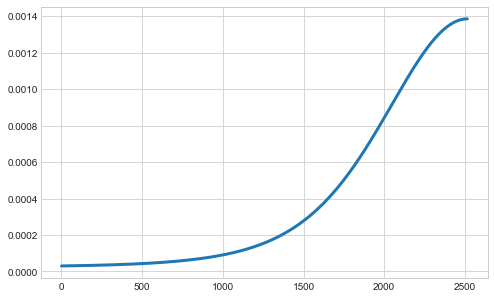

In [7]:
# probablity of date

temp_p = np.arange(len(total_list)) - len(total_list)
temp_p = stats.norm(0, 1000).pdf(temp_p)
temp_p = temp_p / 0.0001
temp_p = softmax(np.expand_dims(temp_p,0)).squeeze(0)
print(temp_p)

f = plt.figure(figsize = (8,5))
plt.plot(np.arange(len(total_list)), temp_p, linewidth=3)

In [9]:
# get 50000 long sentences from 2516 unique long sentences
# then get 50000 short sentences with each containing 20 words

np.random.seed(1993)

ind = np.random.choice(len(total_list), n_sentence, replace=True, p=temp_p)
# ind = np.random.choice(len(total_list), len(total_list), replace=False)
output_list = [get_similar(total_list[i], n_similar) for i in ind]

len(output_list)

50000


Text(0, 0.5, 'number of sampled lists')

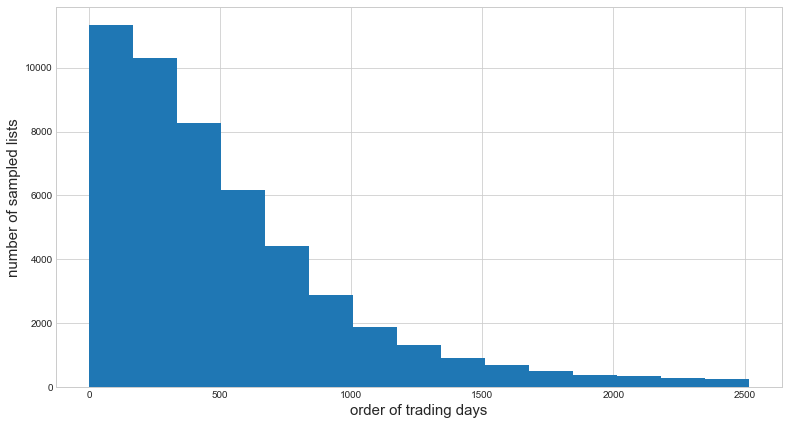

In [18]:
ind_plot = -ind+len(total_list)
f = plt.figure(figsize = (13,7))
plt.hist(ind_plot, bins=15)
plt.xlabel('order of trading days', size=15)
plt.ylabel('number of sampled lists', size=15)

In [19]:
f.savefig('../Data/3000/new/hist_plot.pdf')

In [9]:
# generate training set of embedding

output = [element for lis in output_list for element in lis]
unique_stocks = set(output)
print(len(output))
print(len(unique_stocks))

1000000
3209


In [10]:
out_dir = '../Data/3000/new/stocks_emb_train.txt'
with open(out_dir, 'w', encoding='utf-8') as fout:
        for word in output:
            fout.write(word+' ')
            
out_dir = '../Data/3000/new/symbols.txt'
with open(out_dir, 'w', encoding='utf-8') as fout:
        for word in unique_stocks:
            fout.write(word+'\n')

In [1]:
%run get_vocab.py

In [12]:
# use fastText to train

cmd = "../fastText/fastText-0.9.1/fasttext skipgram -epoch 5 -minCount 0 -dim 100 -thread 12 -ws 5 -neg 5 -input ../Data/3000/new/stocks_emb_train.txt -output ../Data/3000/new/stocks_emb 1>../Data/3000/new/stocks_emb.log 2>&1"

result = subprocess.run(cmd, capture_output=True, text=True, shell=True)
print(result.stdout)
print(result.stderr)

In [1]:
# get .w2vec for next step
%run generate_d2gpo_embedding.py ../Data/3000/new/stocks_emb.bin ../Data/3000/new/stocks_symbols.vocab ../Data/3000/new/stocks_emb.vec ../Data/3000/new/stocks_emb.w2vec


In [8]:
# get cos similarity

with open('../Data/3000/new/stocks_emb.w2vec') as f: # open vector file
    lines = f.readlines()
    a = lines
data = a[1:] # drop the first line with parameters

data[0]

'XNET -0.009019492 -0.026700862 -0.0639068 -0.12993369 0.15612322 -0.18397306 -0.04828879 -0.029106652 -0.028287958 0.09503741 -0.037427083 -0.1551405 -0.006969589 0.101778634 -0.0151538225 -0.016675783 0.06745729 -0.14649259 -0.45754996 0.040339235 0.018548237 0.0069475365 -0.021576129 -0.073624164 0.14381792 -0.22133966 -0.0027976346 -0.032197777 0.15036249 -0.01992511 -0.10788326 0.027235933 -0.002407197 -0.011620539 -0.22499146 0.18169206 0.074253574 -0.07277843 -0.10804245 -0.09245158 -0.060001254 0.12564613 0.06805097 0.006237118 0.020204324 0.052699927 -0.17832462 0.17312671 0.21011929 0.05659364 0.054890487 -0.039807864 0.017200071 0.1480148 0.117960125 -0.012420616 -0.054662216 -0.06025665 -0.2925988 0.046865717 0.016503392 0.060064033 0.12118776 0.058855485 0.099000126 0.043688342 0.03437251 0.013085141 -0.0853923 -0.07764673 0.16435336 0.02249565 -0.20386122 0.0055264486 0.07251137 -0.22272652 0.27529976 0.17367196 -0.1636431 -0.13783862 0.012919181 0.18774325 -0.11981904 0.

In [9]:
df = {}
for i in range(len(data)): # line i is a vector with name and values
    vec = data[i].split(" ")
    name = vec[0]
    vec = vec[1:]
    df[name] = vec

df = pd.DataFrame(df, dtype="float64")
df = df.T

df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
XNET,-0.009019,-0.026701,-0.063907,-0.129934,0.156123,-0.183973,-0.048289,-0.029107,-0.028288,0.095037,...,0.066630,-0.053855,0.004184,-0.127284,0.247012,-0.024860,0.234949,-0.009814,0.164309,-0.139722
ATRI,-0.051096,0.124803,0.004223,-0.218116,0.098172,0.135204,-0.283882,0.171215,-0.102618,-0.059873,...,0.042991,0.142958,-0.034996,-0.133956,0.277610,0.189983,0.149886,-0.003449,0.298517,0.170486
SOHON,0.055863,0.058146,0.014033,-0.090808,0.036000,-0.021043,-0.157227,0.104235,-0.093261,0.047654,...,0.027270,0.086475,-0.093907,-0.120358,0.248020,0.068883,0.265592,0.117468,0.083925,0.015572
PCSB,0.122366,0.013316,-0.024093,-0.115194,0.075843,-0.010962,-0.163869,0.100811,-0.115537,-0.000433,...,0.052237,0.089977,-0.026787,-0.059746,0.272813,0.029916,0.171285,0.045155,0.017859,0.011140
THBRU,0.150930,-0.061108,-0.018299,-0.152943,0.007387,-0.109745,-0.112763,-0.033074,-0.058774,0.079396,...,0.048002,0.024272,0.000675,-0.068437,0.091980,-0.006740,0.184037,0.104647,0.214640,-0.058633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCHL,0.124852,0.078562,-0.028421,-0.266926,0.043854,-0.031953,-0.123886,0.090066,-0.191284,0.021925,...,0.058610,0.019947,-0.059300,-0.118239,0.187348,0.027882,0.178922,0.127134,0.087845,-0.039796
SNOA,0.187979,-0.025663,0.021459,-0.157173,0.048483,-0.063412,-0.146708,0.050202,-0.121075,0.079118,...,-0.051489,-0.073953,0.106163,-0.196414,0.159784,-0.008068,0.106085,0.101196,0.197366,-0.072139
QRTEB,0.112132,0.026014,-0.075072,0.001338,0.035468,-0.262040,-0.180705,-0.054115,0.028639,0.118473,...,-0.006763,0.074945,0.059995,-0.088443,0.163435,0.026648,0.158775,-0.053442,-0.005467,-0.026251
REG,0.156152,0.148026,0.139189,-0.385890,0.200279,-0.163121,-0.348843,0.216779,-0.075974,0.035738,...,0.029533,-0.005740,-0.057719,-0.172487,0.083373,0.121512,0.269653,0.006648,0.152375,0.028005


In [17]:
# get cosine_similarity

cos = pd.DataFrame(cosine_similarity(df), index=df.index, columns= df.index)
cos

,XNET,ATRI,SOHON,PCSB,THBRU,VTIQW,AIMT,RMBL,PI,NDAQ,...,SPSC,SLNO,FFIN,CGO,GFNCP,SCHL,SNOA,QRTEB,REG,SLS
XNET,1.000000,0.299936,0.521320,0.494280,0.582035,0.437632,0.571439,0.523405,0.337413,0.372619,...,0.445813,0.534330,0.384239,0.515187,0.302539,0.556184,0.558445,0.583612,0.368315,0.608073
ATRI,0.299936,1.000000,0.634545,0.514873,0.452864,0.395332,0.441715,0.266480,0.282905,0.590747,...,0.431902,0.414496,0.325668,0.471490,0.563535,0.434256,0.421197,0.360386,0.406731,0.300731
SOHON,0.521320,0.634545,1.000000,0.803573,0.761393,0.713193,0.455550,0.543638,0.396320,0.711388,...,0.503986,0.604222,0.324114,0.705486,0.627132,0.715031,0.563236,0.614582,0.620068,0.539619
PCSB,0.494280,0.514873,0.803573,1.000000,0.662363,0.628387,0.368595,0.457269,0.426670,0.778043,...,0.575352,0.545185,0.507891,0.652400,0.694318,0.692438,0.594158,0.616467,0.599753,0.578218
THBRU,0.582035,0.452864,0.761393,0.662363,1.000000,0.849219,0.533444,0.691587,0.369418,0.395881,...,0.406440,0.612914,0.170670,0.704432,0.246989,0.519284,0.660596,0.684672,0.427717,0.588781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCHL,0.556184,0.434256,0.715031,0.692438,0.519284,0.439730,0.581482,0.454358,0.537572,0.705946,...,0.662595,0.612207,0.397472,0.658018,0.665199,1.000000,0.614785,0.480579,0.637314,0.636739
SNOA,0.558445,0.421197,0.563236,0.594158,0.660596,0.517391,0.535541,0.643757,0.550172,0.475886,...,0.590292,0.655287,0.295710,0.667253,0.405244,0.614785,1.000000,0.605882,0.428279,0.620669
QRTEB,0.583612,0.360386,0.614582,0.616467,0.684672,0.559314,0.450685,0.544268,0.400541,0.420590,...,0.485419,0.539664,0.286852,0.625061,0.277320,0.480579,0.605882,1.000000,0.432250,0.479774
REG,0.368315,0.406731,0.620068,0.599753,0.427717,0.394063,0.457434,0.263401,0.469721,0.662074,...,0.536808,0.439726,0.308988,0.490924,0.634196,0.637314,0.428279,0.432250,1.000000,0.469720


In [19]:
np.min(np.min(cos))

-0.33509658738348935

In [15]:
x = np.array([[1,0],[-1,1]])
cosine_similarity(x)

array([[ 1.        , -0.70710678],
       [-0.70710678,  1.        ]])

In [6]:
print("AAPL","BANF:", cos.loc["AAPL","BANF"])
print("BANF","MSFT:", cos.loc["BANF","MSFT"])
print("AAPL","FRBA:", cos.loc["AAPL","FRBA"])
print("FRBA","MSFT:", cos.loc["FRBA","MSFT"], "\n")

print("BANF","FRBA:", cos.loc["BANF","FRBA"])
print("AAPL","MSFT:", cos.loc["AAPL","MSFT"])

AAPL BANF: 0.3968197506573512
BANF MSFT: 0.5385011436597211
AAPL FRBA: 0.343598067557759
FRBA MSFT: 0.500915260876794 

BANF FRBA: 0.7007089404506561
AAPL MSFT: 0.7648336496197511


In [7]:
print("GOOG","GOOGL:", cos.loc["GOOG","GOOGL"])

GOOG GOOGL: 0.9557539358342512
